# Training CNN for Acoustic Event Detection

Environment

Date: Oct 23, 2019

In [1]:
import json
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

USECASE = "environment"

## Read acoustic feature files

In [2]:
feature_files = glob.glob("../data/" + USECASE + "/*.json")

features = []
for file in feature_files:
    with open(file) as f:
        class_label = file.replace('\\', '/').split('/')[-1].split('-')[0]
        feature = json.load(f)
        features.append({'class_label': class_label, 'feature': feature})
#features

## Extract class labels and MFSCs as a data set

In [3]:
train_data_set = []
class_labels = []
class_label_number = 0
mel_filterbank_size = 0
feature_width = 0
feature_size = 0
for f in features:
    class_label = f['class_label']
    feature = f['feature']
    fs = feature['fs']
    fft_size = feature['fftSize']
    mel_filterbank_size = feature['melFilterbankSize']
    feature_size = feature['featureSize']
    feature_center = feature['featureCenter']
    feature_width = feature['featureWidth']
    mfsc = np.array(feature['mfsc']).reshape(feature_size, mel_filterbank_size)
    x1 = int(feature_center - (feature_width / 2))
    x2 = int(feature_center + (feature_width / 2) - 1)
    if (x1 >= 0 and x2 < feature_size):
        if class_label not in class_labels:
            class_labels.append(class_label)
        train_data_set.append({'class_number': class_labels.index(class_label), 'mfsc':mfsc[x1:x2+1]})
        

## Class labels

In [4]:
class_labels

['eacalator', 'mall', 'station', 'train']

## Pick up a sample for confirmation

0

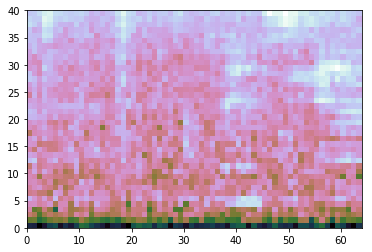

In [5]:
plt.pcolormesh(train_data_set[0]['mfsc'].T, cmap='cubehelix')
train_data_set[0]['class_number']

## Shuffle the data set

0

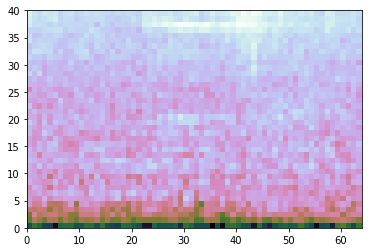

In [6]:
random.shuffle(train_data_set)
train_len = int(len(train_data_set)*2/3)
test_data_set = train_data_set[train_len:]
train_data_set = train_data_set[:train_len]

plt.pcolormesh(train_data_set[0]['mfsc'].T, cmap='cubehelix')
train_data_set[0]['class_number']

## Reshape the data set for Keras/TensorFlow

In [7]:
train_label = []
train_data = []
for e in train_data_set:
    train_label.append(e['class_number'])
    train_data.append(e['mfsc'])
    
test_label = []
test_data = []
for e in test_data_set:
    test_label.append(e['class_number'])
    test_data.append(e['mfsc'])

In [8]:
train_data = np.array(train_data, dtype=np.float32).reshape(len(train_data), feature_width, mel_filterbank_size, 1)
train_label = np.array(train_label, dtype=np.int32)
test_data = np.array(test_data, dtype=np.float32).reshape(len(test_data), feature_width, mel_filterbank_size, 1)
test_lable = np.array(test_label, dtype=np.int32)

In [9]:
train_label=tf.keras.utils.to_categorical(train_label)
test_label=tf.keras.utils.to_categorical(test_label)
train_label

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

## Define a CNN model for Acoustic Event Detection

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(feature_width, mel_filterbank_size, 1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 40, 8)         80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 20, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 20, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 20, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 10, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 10, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 10, 32)        4

In [11]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## Train the model with the data set

In [12]:
EPOCHS = 300
history = model.fit(train_data, train_label, epochs=EPOCHS, validation_data=(test_data, test_label))

Train on 276 samples, validate on 138 samples
Epoch 1/300
276/276 [==============================] - 1s 5ms/sample - loss: 29.8121 - accuracy: 0.2609 - val_loss: 1.9372 - val_accuracy: 0.2174
Epoch 2/300
276/276 [==============================] - 0s 2ms/sample - loss: 2.3786 - accuracy: 0.2572 - val_loss: 1.4342 - val_accuracy: 0.2754
Epoch 3/300
276/276 [==============================] - 0s 2ms/sample - loss: 1.7166 - accuracy: 0.3043 - val_loss: 1.3940 - val_accuracy: 0.2971
Epoch 4/300
276/276 [==============================] - 0s 2ms/sample - loss: 1.6985 - accuracy: 0.2065 - val_loss: 1.3985 - val_accuracy: 0.2464
Epoch 5/300
276/276 [==============================] - 0s 2ms/sample - loss: 1.5524 - accuracy: 0.2645 - val_loss: 1.3958 - val_accuracy: 0.2464
Epoch 6/300
276/276 [==============================] - 0s 2ms/sample - loss: 1.5058 - accuracy: 0.2717 - val_loss: 1.3793 - val_accuracy: 0.2971
Epoch 7/300
276/276 [==============================] - 0s 2ms/sample - loss: 1.4760

Epoch 57/300
276/276 [==============================] - 0s 2ms/sample - loss: 0.9941 - accuracy: 0.5688 - val_loss: 1.2963 - val_accuracy: 0.3913
Epoch 58/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.9190 - accuracy: 0.6051 - val_loss: 1.0222 - val_accuracy: 0.5362
Epoch 59/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.9988 - accuracy: 0.5761 - val_loss: 1.0644 - val_accuracy: 0.5652
Epoch 60/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.8651 - accuracy: 0.5906 - val_loss: 1.2915 - val_accuracy: 0.3986
Epoch 61/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.8671 - accuracy: 0.6051 - val_loss: 1.0956 - val_accuracy: 0.4928
Epoch 62/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.8645 - accuracy: 0.6268 - val_loss: 1.2041 - val_accuracy: 0.4493
Epoch 63/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.9115 - accuracy: 0.6051 - val_loss: 1.0318 -

276/276 [==============================] - 1s 2ms/sample - loss: 0.4172 - accuracy: 0.8333 - val_loss: 1.1260 - val_accuracy: 0.5797
Epoch 114/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.5169 - accuracy: 0.8116 - val_loss: 0.9676 - val_accuracy: 0.6232
Epoch 115/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.4472 - accuracy: 0.8007 - val_loss: 0.8325 - val_accuracy: 0.6957
Epoch 116/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.4628 - accuracy: 0.8116 - val_loss: 0.8346 - val_accuracy: 0.7319
Epoch 117/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.4298 - accuracy: 0.8225 - val_loss: 0.8224 - val_accuracy: 0.6957
Epoch 118/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.5305 - accuracy: 0.8007 - val_loss: 0.9523 - val_accuracy: 0.6449
Epoch 119/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.4265 - accuracy: 0.8261 - val_loss: 1.1695 - val_ac

Epoch 169/300
276/276 [==============================] - 0s 2ms/sample - loss: 0.2998 - accuracy: 0.8841 - val_loss: 0.8665 - val_accuracy: 0.7319
Epoch 170/300
276/276 [==============================] - 0s 2ms/sample - loss: 0.2799 - accuracy: 0.8949 - val_loss: 0.9853 - val_accuracy: 0.7101
Epoch 171/300
276/276 [==============================] - 0s 2ms/sample - loss: 0.2260 - accuracy: 0.9130 - val_loss: 0.9935 - val_accuracy: 0.7391
Epoch 172/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.2197 - accuracy: 0.9203 - val_loss: 1.1282 - val_accuracy: 0.7174
Epoch 173/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.2157 - accuracy: 0.9058 - val_loss: 1.3041 - val_accuracy: 0.6739
Epoch 174/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.1877 - accuracy: 0.9275 - val_loss: 1.1727 - val_accuracy: 0.7464
Epoch 175/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.1834 - accuracy: 0.9203 - val_loss: 1

Epoch 225/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.2868 - accuracy: 0.8949 - val_loss: 1.1772 - val_accuracy: 0.7536
Epoch 226/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.0953 - accuracy: 0.9601 - val_loss: 1.1809 - val_accuracy: 0.6087
Epoch 227/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.2733 - accuracy: 0.9312 - val_loss: 0.8975 - val_accuracy: 0.7681
Epoch 228/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.1430 - accuracy: 0.9275 - val_loss: 1.0032 - val_accuracy: 0.7246
Epoch 229/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.0810 - accuracy: 0.9746 - val_loss: 0.9886 - val_accuracy: 0.7899
Epoch 230/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.0938 - accuracy: 0.9674 - val_loss: 0.8771 - val_accuracy: 0.7536
Epoch 231/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.1758 - accuracy: 0.9348 - val_loss: 1

Epoch 281/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.0921 - accuracy: 0.9710 - val_loss: 1.3384 - val_accuracy: 0.7754
Epoch 282/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.0974 - accuracy: 0.9638 - val_loss: 1.3188 - val_accuracy: 0.7754
Epoch 283/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.0440 - accuracy: 0.9855 - val_loss: 1.2617 - val_accuracy: 0.8043
Epoch 284/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.1437 - accuracy: 0.9529 - val_loss: 1.2336 - val_accuracy: 0.7609
Epoch 285/300
276/276 [==============================] - 1s 2ms/sample - loss: 0.2564 - accuracy: 0.9275 - val_loss: 1.2753 - val_accuracy: 0.7609
Epoch 286/300
276/276 [==============================] - 0s 2ms/sample - loss: 0.0614 - accuracy: 0.9710 - val_loss: 1.2027 - val_accuracy: 0.7609
Epoch 287/300
276/276 [==============================] - 0s 2ms/sample - loss: 0.0302 - accuracy: 0.9928 - val_loss: 1

## Plot the history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


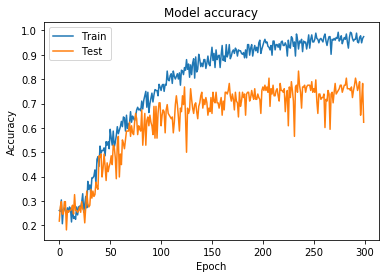

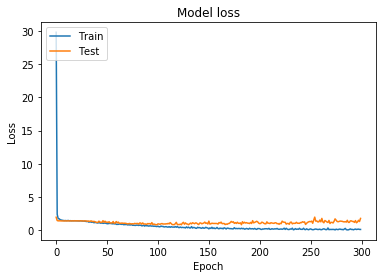

In [13]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Make the model infer test data

In [14]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(276, 64, 40, 1)

In [15]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [16]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)

In [17]:
class_labels

['eacalator', 'mall', 'station', 'train']

In [18]:
(activations[-1][:10]*100).astype(int)

array([[ 0, 98,  0,  1],
       [ 0,  5, 93,  0],
       [98,  1,  0,  0],
       [ 0,  0,  0, 99],
       [ 0,  3,  0, 96],
       [98,  0,  0,  1],
       [ 0,  0, 99,  0],
       [ 0,  0,  0, 99],
       [16, 83,  0,  0],
       [99,  0,  0,  0]])

In [19]:
test_label[:10].astype(int)

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

## Visualze the trained model

'train'

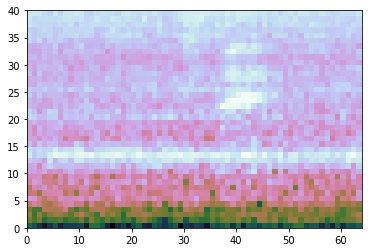

In [20]:
image_number = 3

plt.pcolormesh(test_data[image_number,:,:,0].T, cmap='cubehelix')
class_labels[np.argmax(test_label[image_number])]

In [21]:
def plot_layer(activations, sample, layer, num_columns):
    '''
    Visualize convolution layers and pool layers
    '''
    a = activations[layer].shape
    rows = int(a[3]/num_columns)
    fig, axarr = plt.subplots(rows, num_columns, figsize=[4*num_columns,5])
    for i in range(a[3]):
        row = int(i/num_columns)
        x, y = row, i-num_columns*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]), cmap='gray')
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    fig.tight_layout()

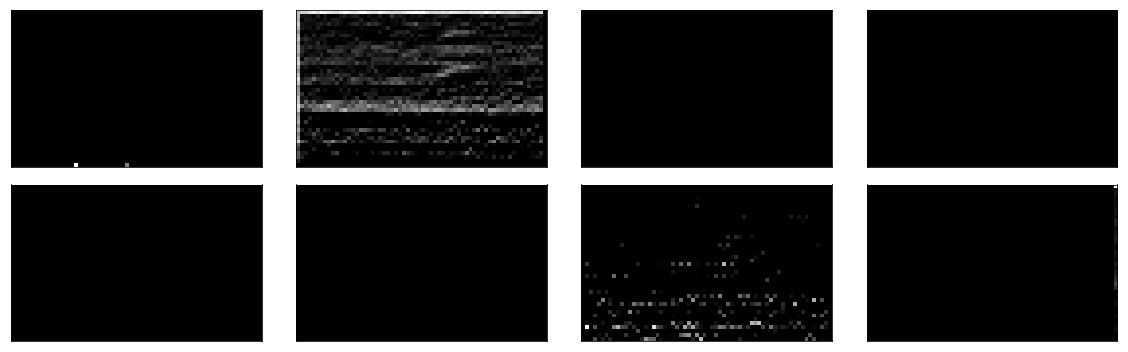

In [22]:
plot_layer(activations, image_number, 0, 4)

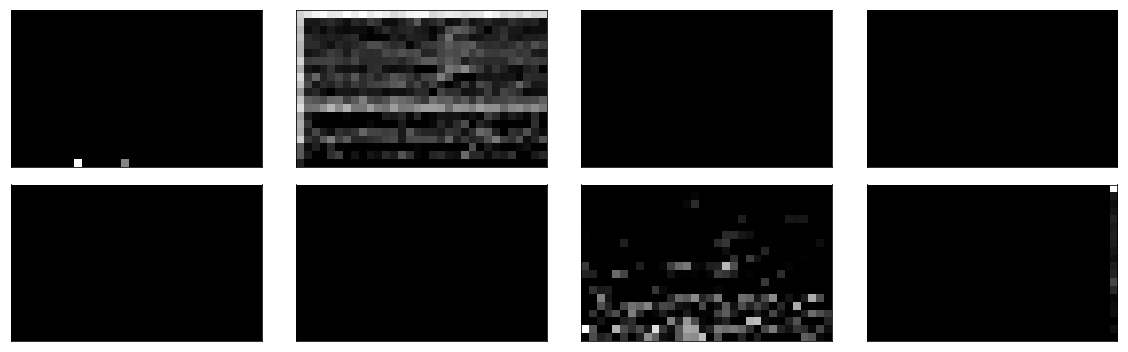

In [23]:
plot_layer(activations, image_number, 2, 4)

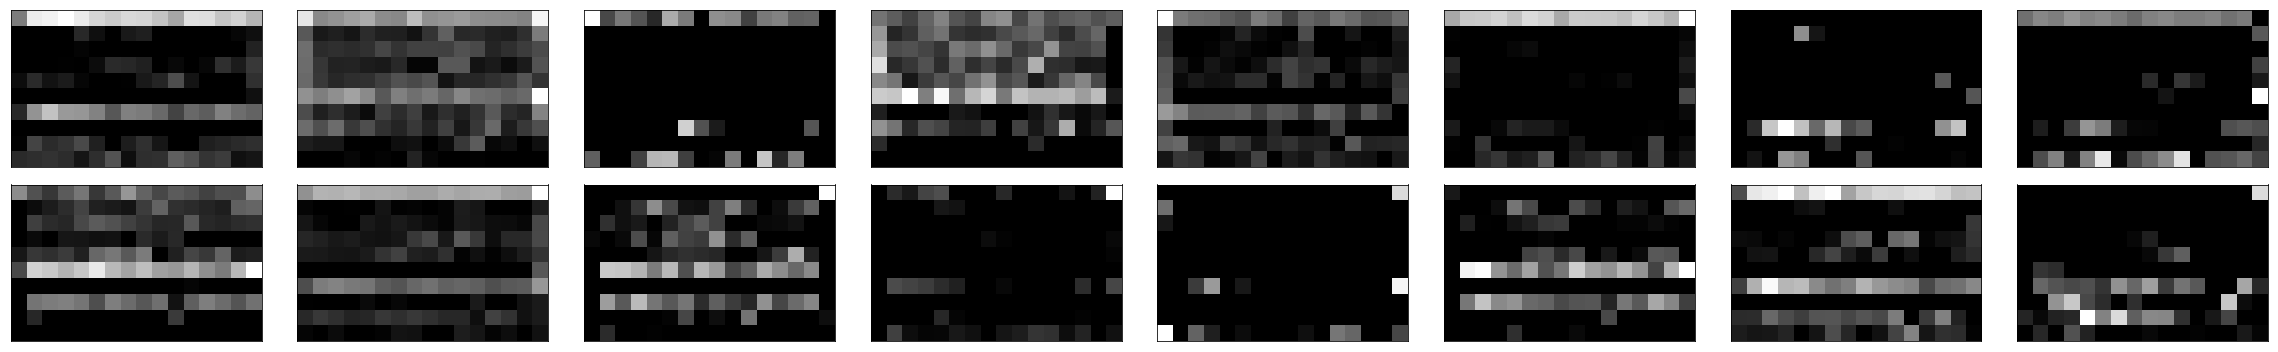

In [24]:
plot_layer(activations, image_number, 4, 8)

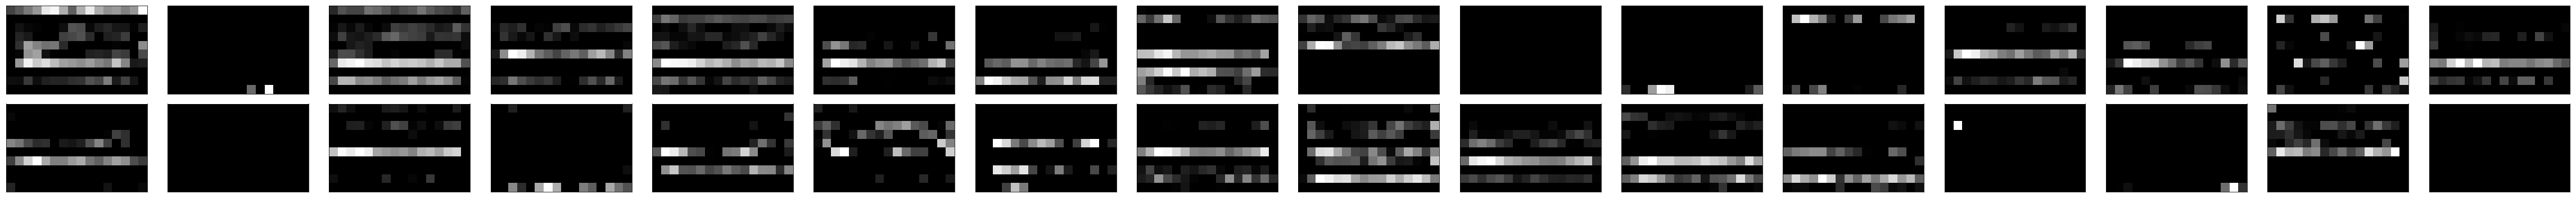

In [25]:
plot_layer(activations, image_number, 6, 16)

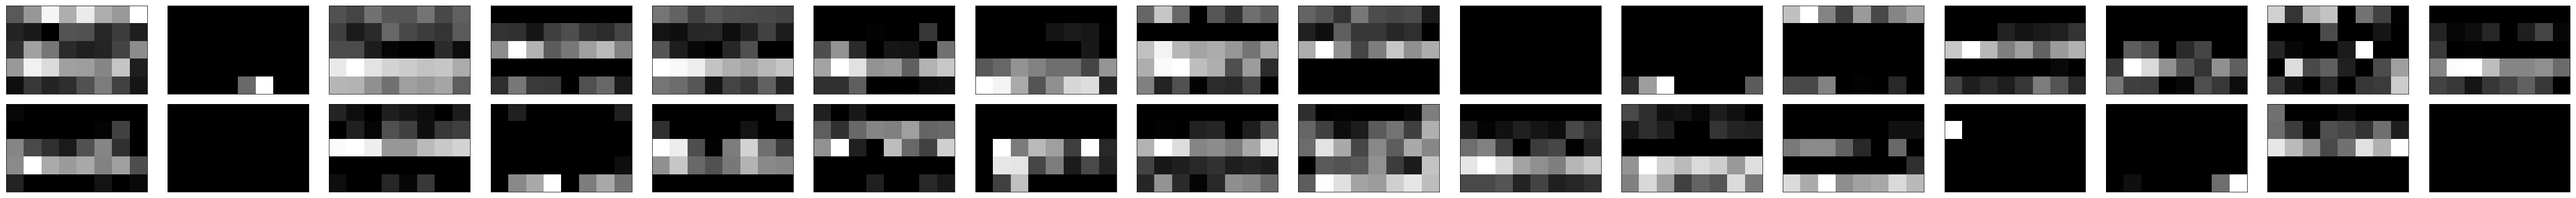

In [26]:
plot_layer(activations, image_number, 8, 16)

## Convert the model into TFLite model

In [27]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

## Save the model

In [28]:
# Save the class labels
with open(USECASE+'-labels.txt', 'w') as f:
    f.write('\n'.join(class_labels))
    f.write('\n')
    
# Save the converted model
open(USECASE+".tflite", "wb").write(tflite_model)

1414152